In [1]:
import pandas as pd
import numpy as np
import skbio.io
from ete3 import NCBITaxa
import os
import subprocess
import pickle
import dendropy
from Bio import Phylo
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint

# Parse blast results

In [2]:
with open('asv_ncbi_microbial16S_top100_hits.blast', 'r') as fh:
    df = skbio.io.read(fh, into=pd.DataFrame)
df.head()

,qaccver,saccver,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,5fb94f804715b4d90f191c413efef44e,NR_146011.1,100.000,427.0,0.0,0.0,1.0,427.0,347.0,773.0,0.000000e+00,789.0
1,5fb94f804715b4d90f191c413efef44e,NR_042110.1,89.145,433.0,34.0,12.0,1.0,427.0,323.0,748.0,2.130000e-149,527.0
2,5fb94f804715b4d90f191c413efef44e,NR_156910.1,87.907,430.0,46.0,6.0,1.0,427.0,327.0,753.0,1.290000e-141,501.0
3,5fb94f804715b4d90f191c413efef44e,NR_113163.1,87.907,430.0,45.0,7.0,1.0,427.0,359.0,784.0,4.650000e-141,499.0
4,5fb94f804715b4d90f191c413efef44e,NR_118672.1,87.674,430.0,46.0,7.0,1.0,427.0,366.0,791.0,6.020000e-140,496.0


In [3]:
# keep the top hits
all_asvs = list(set(df.qaccver))
index_to_keep = []
for asv in all_asvs:
    df_tmp = df[df.qaccver==asv].sort_values(by='evalue')
    df_tmp = df_tmp[df_tmp.evalue==df_tmp.iloc[0]['evalue']]
    index_to_keep.extend(list(df_tmp.index)) 
df = df.loc[index_to_keep].reset_index(drop=True)
df.head()

,qaccver,saccver,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,30bedc56d781e8612120ba609f2e4889,NR_074535.1,84.870,423.0,43.0,10.0,1.0,404.0,351.0,771.0,2.740000e-113,407.0
1,30bedc56d781e8612120ba609f2e4889,NR_113075.1,84.870,423.0,43.0,10.0,1.0,404.0,351.0,771.0,2.740000e-113,407.0
2,871184f055ce26efdf43303c09277a38,NR_156080.1,97.015,402.0,12.0,0.0,1.0,402.0,353.0,754.0,0.000000e+00,676.0
3,871184f055ce26efdf43303c09277a38,NR_044289.1,95.025,402.0,20.0,0.0,1.0,402.0,345.0,746.0,0.000000e+00,632.0
4,871184f055ce26efdf43303c09277a38,NR_134772.1,95.037,403.0,18.0,2.0,1.0,402.0,314.0,715.0,0.000000e+00,632.0


In [42]:
unique_saccver = list(set(df['saccver']))
try:
    acc2taxid
except NameError:
    acc2taxid = {}
    
manual_curation = {'NR_028951.1':'163202',
                   'NR_137237.1':'1515612',
                   'NR_024706.1':'1336237',
                   'NR_116026.1':'29489',
                   'NR_112816.1':'229204',
                   'NR_117163.1':'48256',
                   'NR_041457.1':'381742',
                   'NR_113140.1':'1505',
                   'NR_148578.1':'1324864'
                  }
    
for idx, acc in enumerate(unique_saccver):
    if acc not in acc2taxid.keys():
        if acc in manual_curation.keys():
            acc2taxid[acc] = manual_curation[acc]
        else:
            command = "/Users/liaoc/edirect/esearch -db nuccore -query " + acc + "|/Users/liaoc/edirect/elink -target taxonomy|/Users/liaoc/edirect/efetch -format uid"
            acc2taxid[acc] = subprocess.check_output(command, shell=True).decode("utf-8").rstrip('\n') 
    if (idx % 100 == 0):
        print(idx)
pickle.dump(acc2taxid, open("acc2taxid.p", "wb" ))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600


In [4]:
acc2taxid = pickle.load( open( "acc2taxid.p", "rb" ) )

ncbi = NCBITaxa()
desired_ranks = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

# taxa id merged
merged_table = {}

try:
    ncbiid_species200
except NameError:
    ncbi_rank = {'kingdom':[],
                 'phylum':[],
                 'class':[],
                 'order':[],
                 'family':[],
                 'genus':[],
                 'species':[]}
    ncbiid_species = []
    ncbiid_genus = []
    max_index = -1

for index, row in df.iterrows(): 
    if index < max_index:
        continue
    else:
        max_index = index
        
    taxid = acc2taxid[row.saccver]
    
    # resolve incompatible taxid
    if taxid in merged_table:
        taxid = merged_table[taxid] 
        
    # get lineage
    try:
        lineage = ncbi.get_lineage(taxid)
        lineage2ranks = ncbi.get_rank(lineage)
    except:
        print(row.saccver)
        print(taxid)
        print(lineage)
        raise

    # use superkingdom as kingdom
    ranks2lineage = dict((rank, taxid) for (taxid, rank) in lineage2ranks.items())
    if 'kingdom' not in ranks2lineage.keys():
        ranks2lineage['kingdom'] = ranks2lineage.get('superkingdom', '')

    replace_text = {}
    for rank in desired_ranks:
        rank_id = ranks2lineage.get(rank, '')
        if rank_id == '':
            ncbi_rank[rank].append('')
        else:
            ncbi_rank[rank].append(ncbi.get_taxid_translator([rank_id])[rank_id])
            
df['kingdom']=ncbi_rank['kingdom']
df['phylum']=ncbi_rank['phylum']
df['class']=ncbi_rank['class']
df['order']=ncbi_rank['order']
df['family']=ncbi_rank['family']
df['genus']=ncbi_rank['genus']
df['species']=ncbi_rank['species']
df.head()

,qaccver,saccver,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,kingdom,phylum,class,order,family,genus,species
0,30bedc56d781e8612120ba609f2e4889,NR_074535.1,84.870,423.0,43.0,10.0,1.0,404.0,351.0,771.0,2.740000e-113,407.0,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Odoribacteraceae,Odoribacter,Odoribacter splanchnicus
1,30bedc56d781e8612120ba609f2e4889,NR_113075.1,84.870,423.0,43.0,10.0,1.0,404.0,351.0,771.0,2.740000e-113,407.0,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Odoribacteraceae,Odoribacter,Odoribacter splanchnicus
2,871184f055ce26efdf43303c09277a38,NR_156080.1,97.015,402.0,12.0,0.0,1.0,402.0,353.0,754.0,0.000000e+00,676.0,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Kineothrix,Kineothrix alysoides
3,871184f055ce26efdf43303c09277a38,NR_044289.1,95.025,402.0,20.0,0.0,1.0,402.0,345.0,746.0,0.000000e+00,632.0,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Enterocloster,Enterocloster lavalensis
4,871184f055ce26efdf43303c09277a38,NR_134772.1,95.037,403.0,18.0,2.0,1.0,402.0,314.0,715.0,0.000000e+00,632.0,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Murimonas,Murimonas intestini


# Read NJC19

In [19]:
df_njc = pd.read_csv('NJC19.csv')
df_njc = df_njc[df_njc['Small-molecule metabolite or macromolecule'].isin(['Acetate','Butyrate', 'Propanoate (Propionate)'])]
df_njc = df_njc[['Species','Small-molecule metabolite or macromolecule','Metabolic activity']]
df_njc.columns = ['species','molecule','activity']
df_njc = df_njc[~df_njc.activity.str.contains('(-)')] # remove negative phenotypes
df_njc = df_njc[df_njc.activity.str.contains('(export)')] # only consider producer
df_njc = df_njc.drop('activity', axis=1)
df_njc['is_producer']=1
df_njc = pd.pivot_table(data=df_njc, index='species', columns='molecule', values='is_producer').reset_index().fillna(0)
df_njc.index.name = None
df_njc.columns = ['species','Acetate','Butyrate','Propionate']
df_njc.head()

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,species,Acetate,Butyrate,Propionate
0,Absiella dolichum,1.0,1.0,0.0
1,Acetoanaerobium sticklandii,1.0,1.0,1.0
2,Acetobacter pasteurianus,1.0,0.0,0.0
3,Acetobacterium woodii,1.0,0.0,0.0
4,Acetohalobium arabaticum,1.0,0.0,0.0


# Find SCFA producers

In [20]:
df_producer = df[['qaccver','species']]
df_producer = pd.merge(df_producer, df_njc, left_on='species', right_on='species', how='left').fillna(0)
df_producer.columns = ['ASV','Species','IsAcetateProducer','IsButyrateProducer','IsPropionateProducer']
df_producer = df_producer.drop('Species', axis=1)
df_producer = df_producer.groupby('ASV').agg(sum)
df_producer[df_producer>0.5]=1
df_producer.head()

,IsAcetateProducer,IsButyrateProducer,IsPropionateProducer
ASV,,,
00018d3f623ee7401f834d27ba565897,1.0,1.0,0.0
00105152f972067ec3030c86d2413cb5,1.0,0.0,0.0
00176b87ffffd210d7fa50c3a4f9bdc0,0.0,0.0,0.0
002c4d1d7cc9d2da59a1c93e602e42b0,0.0,0.0,0.0
00398f0ccf0ca0e27bc80a606310bced,0.0,0.0,0.0


In [21]:
df_tax = pd.read_csv('taxonomy.csv', index_col=0)
df_tax = pd.merge(df_tax, df_producer, left_index=True, right_index=True, how='left').fillna(0)
df_tax.to_csv('taxonomy.csv')
df_tax.head()

,Confidence,Kingdom,Phylum,Class,Order,Family,Genus,Species,LowestClassifiedTaxon_Species,LowestClassifiedTaxon_Genus,LowestClassifiedTaxon_Family,LowestClassifiedTaxon_Order,LowestClassifiedTaxon_Class,LowestClassifiedTaxon_Phylum,IsAcetateProducer,IsButyrateProducer,IsPropionateProducer
ASV,,,,,,,,,,,,,,,,,
672ec931466c5cbb3d24a0bfe429081a,0.868217,Bacteria,Firmicutes,Clostridia,Clostridia-UCG-014,uncultured-Firmicutes-bacterium,unclassified,unclassified,Clostridia-UCG-014,Clostridia-UCG-014,Clostridia-UCG-014,Clostridia-UCG-014,Clostridia,Firmicutes,0.0,0.0,0.0
f9a0f152d1e38da0a8c3af4946338341,0.997812,Bacteria,Firmicutes,Clostridia,Clostridia-vadinBB60-group,uncultured-bacterium,unclassified,unclassified,Clostridia-vadinBB60-group,Clostridia-vadinBB60-group,Clostridia-vadinBB60-group,Clostridia-vadinBB60-group,Clostridia,Firmicutes,0.0,0.0,0.0
9f0bbcabda2399eea0e437030f464f63,0.998060,Bacteria,Firmicutes,Clostridia,Clostridia-vadinBB60-group,uncultured-bacterium,unclassified,unclassified,Clostridia-vadinBB60-group,Clostridia-vadinBB60-group,Clostridia-vadinBB60-group,Clostridia-vadinBB60-group,Clostridia,Firmicutes,0.0,0.0,0.0
44958330e81e18a06d9a9108d5469c4d,0.998535,Bacteria,Firmicutes,Clostridia,Clostridia-vadinBB60-group,uncultured-bacterium,unclassified,unclassified,Clostridia-vadinBB60-group,Clostridia-vadinBB60-group,Clostridia-vadinBB60-group,Clostridia-vadinBB60-group,Clostridia,Firmicutes,0.0,0.0,0.0
e900e85f23b48faf3b225dd67d2cde43,0.986061,Bacteria,Firmicutes,Clostridia,Clostridia-vadinBB60-group,uncultured-bacterium,unclassified,unclassified,Clostridia-vadinBB60-group,Clostridia-vadinBB60-group,Clostridia-vadinBB60-group,Clostridia-vadinBB60-group,Clostridia,Firmicutes,0.0,0.0,0.0


# Show scatterplot of SCFA producer absolute abundance and SCFA concentration

In [25]:
df_16S_absab_asv = pd.read_csv('16S_absolute_abundance_asv.csv', index_col=0)
df_16S_absab_asv.head()

,sample131,sample132,sample133,sample134,sample135,sample136,sample137,sample138,sample139,sample140,...,sample121,sample122,sample123,sample124,sample125,sample126,sample127,sample128,sample129,sample130
#OTU ID,,,,,,,,,,,,,,,,,,,,,
5fb94f804715b4d90f191c413efef44e,2.166833e+07,1.711936e+07,1.241920e+07,2.454425e+07,1.914741e+07,4.464711e+07,1.123363e+07,1.363613e+07,2.142915e+07,2.100581e+07,...,3.190715e+06,1.686182e+06,1.893493e+06,4.023342e+06,3.898104e+06,8.313344e+06,1.694157e+07,1.888742e+07,1.642809e+07,1.309764e+07
a8eb3e86e896febff5f3e223f84ba94b,1.038631e+05,5.916724e+04,4.629709e+04,1.841508e+05,7.222892e+04,1.689406e+05,5.321192e+04,4.805580e+04,3.547760e+04,8.617250e+04,...,6.684782e+05,8.378922e+04,2.740583e+05,2.042437e+06,2.696211e+05,9.448843e+05,7.582095e+05,8.098243e+04,5.824408e+05,2.014107e+05
dfa833b266bd2993b86feab3617b34c3,3.771030e+06,2.610641e+06,3.729327e+06,2.262880e+07,4.727624e+06,3.581541e+06,1.197268e+06,4.444576e+06,2.812964e+06,2.770192e+06,...,1.707608e+04,9.174002e+03,2.051773e+04,2.381850e+04,1.073119e+04,1.452992e+07,3.244784e+07,2.054756e+07,1.102423e+07,1.985863e+07
b6635d67cb594473ddba9f8cfba5d13d,1.189543e+05,8.292516e+05,2.377549e+05,1.104905e+06,2.349848e+05,3.352822e+05,2.473369e+05,4.653208e+05,1.009747e+05,0.000000e+00,...,3.338876e+06,8.049269e+06,6.186096e+06,1.833826e+07,4.651299e+06,6.626848e+06,7.122467e+06,7.847197e+06,1.720500e+06,3.523771e+06
1dcd5cddd286ba7e9e4786d8d8c1d201,9.662820e+06,2.648872e+05,1.019501e+06,3.638065e+06,1.746977e+06,1.413903e+06,6.307583e+06,4.632111e+06,5.137430e+05,7.775800e+06,...,7.533564e+03,6.116001e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.819626e+04,4.511878e+04,2.873886e+04,2.197207e+04


In [39]:
df_meta = pd.read_csv('meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_scfa = pd.read_csv('SCFA.csv', index_col=0)
df_scfa_meta = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_meta.head()

,MiceID,Vendor,Day,Diet,RandomizedGroup,Acetate,Propionate,Butyrate,Total
SampleID,,,,,,,,,
sample141,BI1,Beijing,0,Inulin,A,5.233899,1.930933,1.109582,8.702693
sample142,BI2,Beijing,0,Inulin,B,13.459823,3.621771,1.546647,19.235932
sample143,BI3,Beijing,0,Inulin,D,18.075378,2.859916,1.682656,23.217751
sample144,BI4,Beijing,0,Inulin,E,12.580368,3.148773,1.477688,17.614381
sample145,BI5,Beijing,0,Inulin,C,8.065127,3.134209,1.835172,13.577951


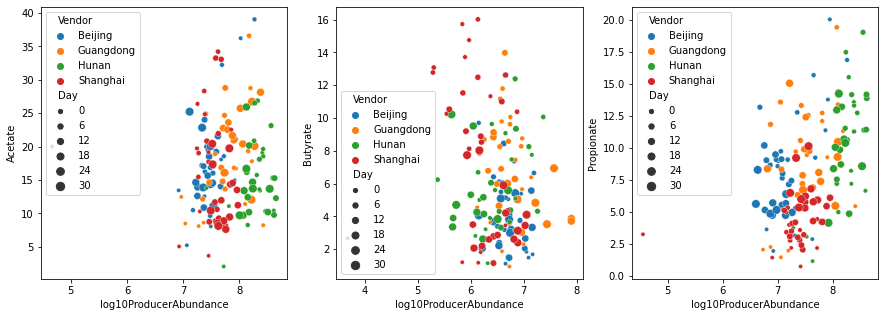

In [55]:
fig, ax= plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    total_producer_absab = df_16S_absab_asv.loc[list(df_tax[df_tax['Is%sProducer'%(scfa)]==1].index)].sum().to_frame()
    total_producer_absab.columns = ['ProducerAbundance']
    total_producer_absab['log10ProducerAbundance'] = np.log10(total_producer_absab['ProducerAbundance'])
    curr_df = pd.merge(df_scfa_meta, total_producer_absab, left_index=True, right_index=True, how='inner')
    _ = sns.scatterplot(x='log10ProducerAbundance', y=scfa, hue='Vendor', size='Day', data=curr_df, ax=ax[k])
    #_ = ax[k].set_xlim([5,9])